In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the numpy array X from the compressed .npz file
X_train = np.load('/content/drive/MyDrive/X_train.npz')
X_test  = np.load('/content/drive/MyDrive/X_test.npz')

Y_train = np.load('/content/drive/MyDrive/Y_train.npz')
Y_test  = np.load('/content/drive/MyDrive/Y_test.npz')


X_train =X_train['X']
X_test  =X_test ['X']

Y_train =Y_train['X']
Y_test  =Y_test ['X']

'''autoencoder is a method of dimensionality reduction where it consists of encoder and decoder , the input is passed to the encoder to reduce its dimension
 this reduced dimension can be used in anything you want , for example (compression , input to a neural network , ...)
 the decoder can reconstruct the reduced dimension back to the normal dimension
 the accuracy of the encoder-decoder is measured by adding the encoder to the decoder together , and comparing the output of their combination with the intial input

An autoencoder is a neural network architecture used for dimensionality reduction and feature extraction. It consists of two main parts: an encoder and a decoder.
The encoder compresses the input into a lower-dimensional latent representation, capturing its most essential features. This reduced representation can be utilized for various tasks,
such as data compression, anomaly detection, or as input to other machine learning models. The decoder reconstructs the original input from the compressed representation,
aiming to preserve as much information as possible. The accuracy of an autoencoder is evaluated by comparing the reconstructed output (produced by the combination of encoder and decoder) with the original input,
typically using a reconstruction loss function like mean squared error (MSE) to quantify the difference.'''

Mounted at /content/drive


'autoencoder is a method of dimensionality reduction where it consists of encoder and decoder , the input is passed to the encoder to reduce its dimension \n this reduced dimension can be used in anything you want , for example (compression , input to a neural network , ...)\n the decoder can reconstruct the reduced dimension back to the normal dimension\n the accuracy of the encoder-decoder is measured by adding the encoder to the decoder together , and comparing the output of their combination with the intial input\n \nAn autoencoder is a neural network architecture used for dimensionality reduction and feature extraction. It consists of two main parts: an encoder and a decoder.\nThe encoder compresses the input into a lower-dimensional latent representation, capturing its most essential features. This reduced representation can be utilized for various tasks,\nsuch as data compression, anomaly detection, or as input to other machine learning models. The decoder reconstructs the origi

In [ ]:
def build_vanilla_autoencoder(input_shape, hidden_layers):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Flatten()(input_layer)
    for neurons in hidden_layers:
        x = Dense(neurons, activation="relu")(x)
    encoded = x

    # Decoder
    for neurons in reversed(hidden_layers):
        x = Dense(neurons, activation="relu")(x)
    x = Dense(np.prod(input_shape), activation="sigmoid")(x)
    decoded = Reshape(input_shape)(x)

    # Autoencoder
    autoencoder = Model(input_layer, decoded)
    # Encoder model
    encoder = Model(input_layer, encoded)
    #decoder model
    decoder = Model(encoded, decoded)

    return autoencoder, encoder, decoder

In [ ]:
#with crossvalidation tawel we mo2rf 5 sa3at leeeeeeeeeh
def cross_validate_autoencoder(X, hidden_layer_configs,folds = 5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    input_shape = X.shape[1:]



    histories = {}   #save the history of each configuration training
    best_loss_ever = float('inf')  # Initialize the best loss
    best_AutoEncoder = None  # Placeholder for the best model
    best_Encoder = None
    best_Decoder = None

    for hidden_layers in hidden_layer_configs:
        best_fold_history = None
        best_fold_loss=float('inf')

        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

            # Build and compile the autoencoder
            autoencoder, encoder, decoder = build_vanilla_autoencoder(input_shape, hidden_layers)
            autoencoder.compile(optimizer="nadam", loss="mse",metrics =["accuracy"])

            # Train the autoencoder
            history = autoencoder.fit(X_train, X_train,
                                       epochs=10,
                                       batch_size=32,
                                       validation_data=(X_val, X_val),
                                       callbacks=[early_stop],
                                       verbose=1)

            # Evaluate on validation data
            loss = history.history['val_loss'][9]

            #target is to save the history for best crossvalidation
            if loss < best_fold_loss:
                best_fold_loss = loss
                best_fold_history = history  # Save the best fold's training history


            #save the model with best configuration
            if loss < best_loss_ever:
                best_loss_ever= loss
                best_AutoEncoder  = autoencoder     # Save the current best model
                best_Encoder  = encoder
                best_Decoder  = decoder

        histories[str(hidden_layers)] = best_fold_history  # Store the history for the best fold

    return  histories ,best_AutoEncoder,best_Encoder,best_Decoder


In [ ]:

hidden_layer_configs = [
    [64],               # Single hidden layer with 64 neurons
    [128 ,64],
    [256, 128],
    [256 , 128 ,64],
    [512 ,256, 128],
    [512 ,256, 128,64],
    [1024,512 ,256, 128],
]
# Perform cross-validation
histories,autoencoder,encoder,decoder= cross_validate_autoencoder(X_train, hidden_layer_configs ,folds = 5 )

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9642 - loss: 0.0037 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9992 - loss: 0.0017 - val_accuracy: 0.9992 - val_loss: 0.0015
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9993 - loss: 0.0015 - val_accuracy: 0.9992 - val_loss: 0.0015
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9993 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9993 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9993 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9992 - loss: 0.0013 - val_accuracy: 0.9992 - val_loss: 0.0014
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9992 - loss: 0.0013 - val_accuracy: 0

In [ ]:
autoencoder.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 256)                 │       3,145,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 12288)               │       3,158,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_11 (Reshape)                 │ (None, 64, 64, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,159,299 (73.09 MB)

 Trainable params: 6,386,432 (24.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,772,867 (48.72 MB)

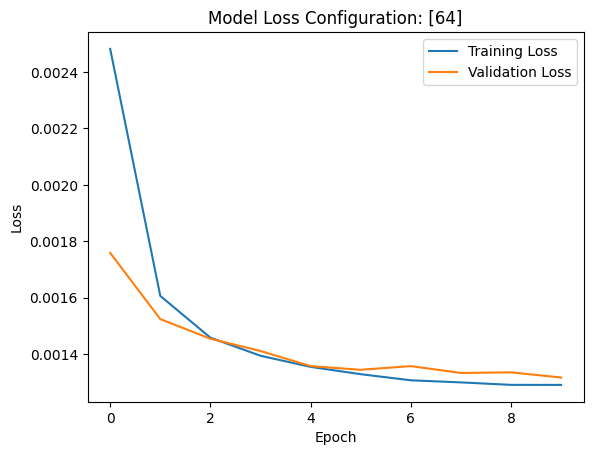

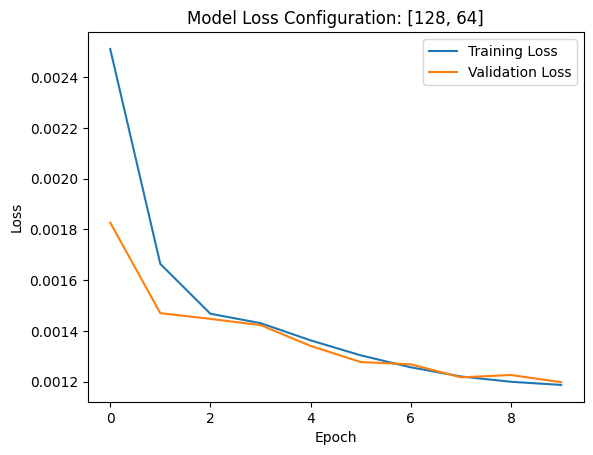

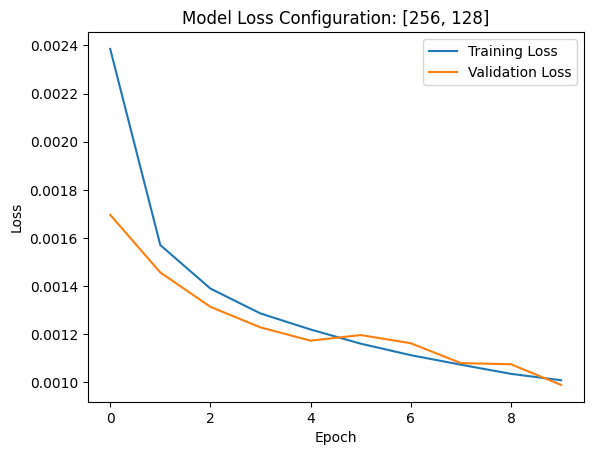

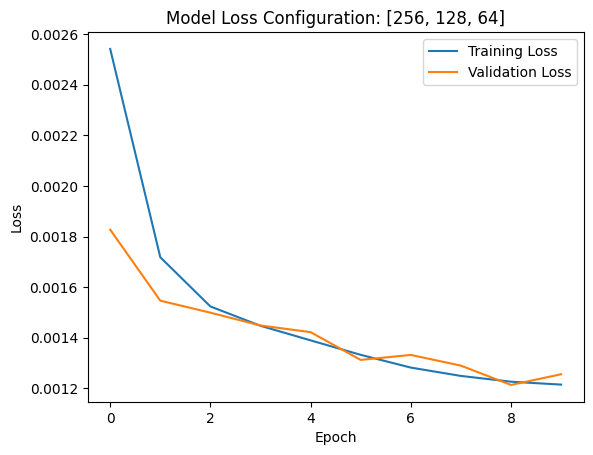

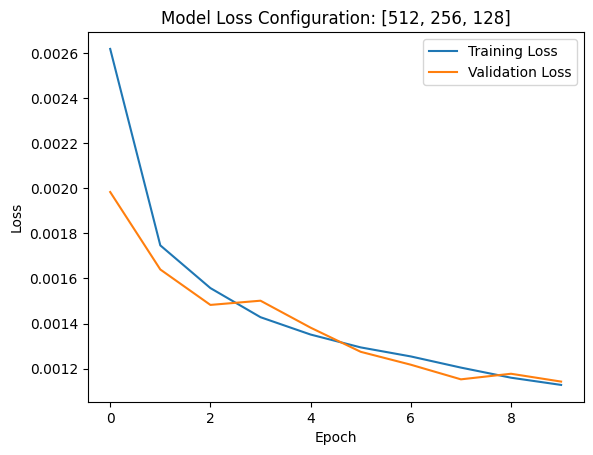

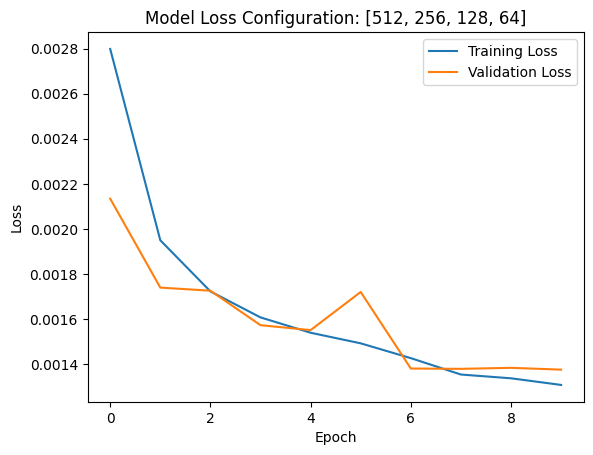

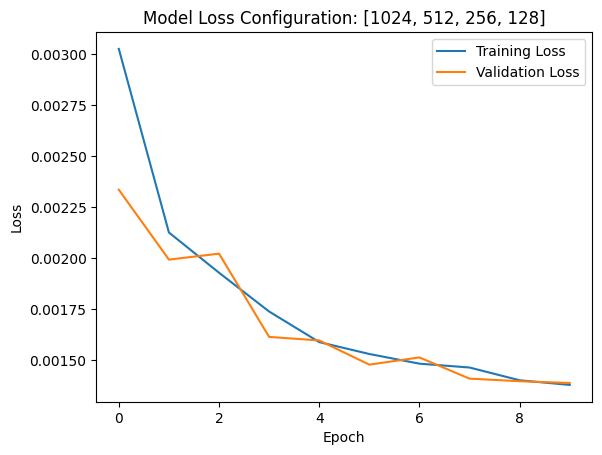

In [ ]:
for i,_ in enumerate(hidden_layer_configs):
    key = list(histories.keys())[i]  # Get the second key in the dictionary
    history = histories[key]


    loss = history.history['loss']
    val_accuracy = history.history['val_loss']
    plt.plot(loss, label='Training Loss')
    plt.plot(val_accuracy, label='Validation Loss')
    plt.title(f"Model Loss Configuration: {key}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
#Accuracy
def accuracy(y_test1, y_pred1):
    y_pred1 = np.array(y_pred1)
    counter = 0
    for i in range(len(y_pred1)):
      if (y_pred1[i] == y_test1[i]):
        counter += 1
    accuracy = counter / len(y_pred1)
    accuracy *= 100
    return accuracy


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# visualizing the results
def visualize_results(y_test,y_predict):
    #class_names = [folder for folder in os.listdir(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories") if os.path.isdir(os.path.join(r"E:\APPS\PythonDataSets\caltech\caltech-101\101_ObjectCategories\filtered_preprocessed_categories", folder))]
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Calculate accuracy for each class
    class_accuracies = (cm.diagonal() / cm.sum(axis=1)) * 100

    # Display class-wise accuracy
    #classes = [f"Class {i}" for i in range(len(class_accuracies))]  # Replace with actual class names if available
    array = np.arange(0, 200)
    # Plot the accuracies
    plt.figure(figsize=(15, 5))
    plt.bar(array, class_accuracies, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Class-Wise Accuracy")
    plt.xticks(rotation=90)
    plt.ylim(0, 100)  # Accuracy is in percentage
    plt.tight_layout()
    plt.show()

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


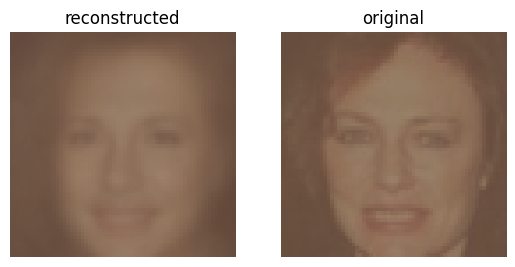

In [ ]:

SS = autoencoder.predict(X_test)
plt.subplot(1, 2, 1)
plt.imshow(SS[200])
plt.axis('off')
plt.title(f"reconstructed")


plt.subplot(1, 2, 2)
plt.imshow(X_test[200])
plt.axis('off')
plt.title(f"original")
plt.show()


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


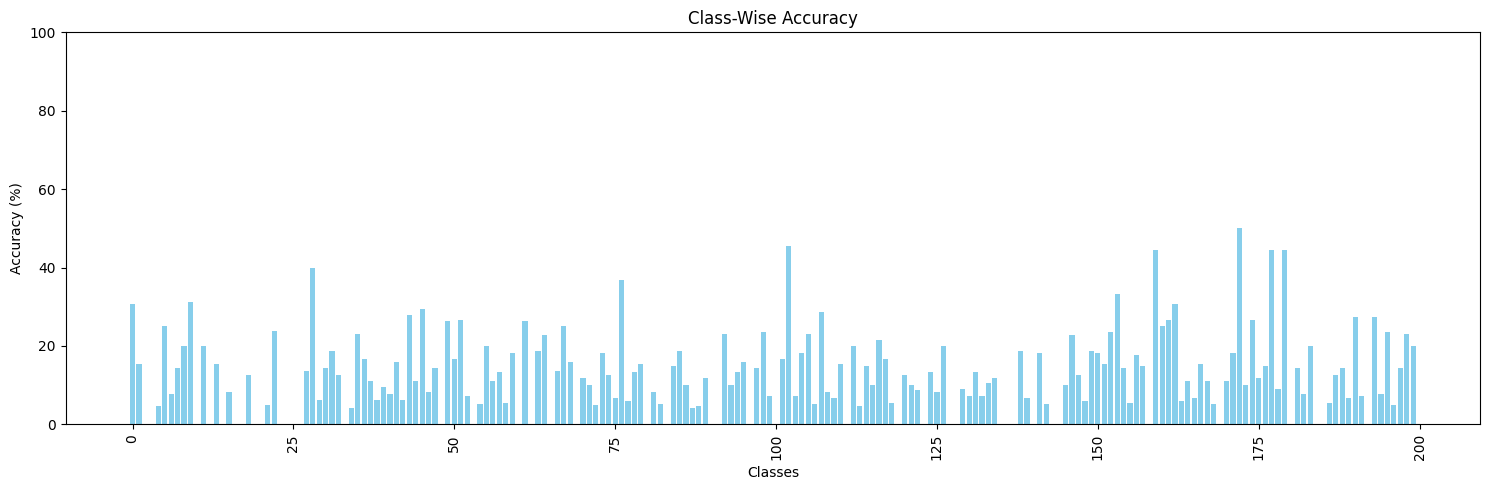

In [ ]:
#ecludian distance classifer "NN"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

feature_vector_test = encoder.predict(X_test)
feature_vector_train =encoder.predict(X_train)



knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(feature_vector_train, Y_train)
predictions = knn.predict(feature_vector_test)
accuracy(Y_test, predictions)
visualize_results(Y_test,predictions)
